In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create entry directory if not exist

import os
base_dir = "/content/drive/MyDrive"

tl_wf_dir = os.path.join(base_dir, "asl_tl_wf")
if not os.path.exists(tl_wf_dir) or not os.path.isdir(tl_wf_dir):
  os.makedirs(tl_wf_dir)

In [ ]:
# create structrual 29 ASL alphabets train/test directory

# alphabet names
asl_names = [chr(i) for i in range(97, 123)] + ["del", "nothing", "space"]
print(asl_names)

# training
train_path = os.path.join(tl_wf_dir, "asl_tl_train")
if not os.path.exists(train_path) or not os.path.isdir(train_path):
  os.makedirs(train_path)
for name in asl_names:
  name_path = os.path.join(train_path, name)
  if not os.path.exists(name_path) or not os.path.isdir(name_path):
    os.makedirs(name_path)

# testing
test_path = os.path.join(tl_wf_dir, "asl_tl_test")
if not os.path.exists(test_path) or not os.path.isdir(test_path):
  os.makedirs(test_path)
for name in asl_names:
  name_path = os.path.join(test_path, name)
  if not os.path.exists(name_path) or not os.path.isdir(name_path):
    os.makedirs(name_path)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'del', 'nothing', 'space']


In [ ]:
# clear the data content

for path in [train_path, test_path]:
  for root, _, files in os.walk(path):
    for file in files:
      os.remove(os.path.join(root, file))

In [ ]:
# create the dataset from ASL video clips

import cv2
import random
asl_video_dir = os.path.join(tl_wf_dir, "asl_videos")

for name in asl_names:
  video_name = os.path.join(asl_video_dir, name) + ".mp4"
  cap = cv2.VideoCapture(video_name)

  cnt = 0
  frame_skip = 1
  while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    if cnt % frame_skip == 0:
      p = random.uniform(0, 1)

      # select data directory to save the frame
      data_dir = "asl_tl_test" if p > 0.8 else "asl_tl_train"
      data_name = os.path.join(tl_wf_dir, data_dir, name, str(cnt)) + ".png"

      cv2.imwrite(data_name, frame)
    cnt += 1

  cap.release()

In [ ]:
# install torch libraries

!pip install torchvision
!pip install tqdm
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import pytorch libraries

import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets

In [ ]:
# define data transforms

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [ ]:
# load data to dataloaders

train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(test_path, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=512)

#print class to index mapping
print(f"class to index mapping: {train_data.class_to_idx}")

class to index mapping: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'del': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'nothing': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 'space': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}


In [ ]:
# load the pretrained model

# choose a pretrained model to start with check options here: https://pytorch.org/vision/stable/models.html
model = models.mobilenet_v2(pretrained=True)

# Freeze parameters of the tarined network
for param in model.parameters():
    param.requires_grad = False

#print the model to check the classifer and change it
print(model.classifier)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 76.0MB/s]


Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [ ]:
# define the training layers

# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=29, bias=True),
                                nn.LogSoftmax(dim=1))

# unlock last three blocks before the classifier(last layer).
for p in model.features[-3:].parameters():
    p.requires_grad = True


# choose your loss function
criterion = nn.NLLLoss()

# define optimizer to train only the classifier and the previous three block.
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        {'params':model.features[-2].parameters()},
                        {'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

#print the classifier now
print(model.classifier)

Sequential(
  (0): Dropout(p=0.6, inplace=False)
  (1): Linear(in_features=1280, out_features=29, bias=True)
  (2): LogSoftmax(dim=1)
)


In [ ]:
# import other utils

import numpy as np
import matplotlib.pyplot as plt

image number 182
---------------------
label: o
prediction: n


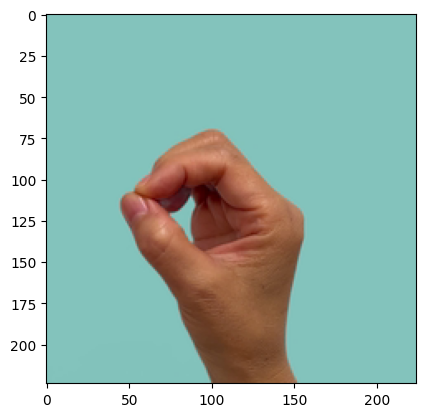

In [ ]:
### try your model on some images
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#turn model to evaluation mode
model.eval()

#load some of the test data
test_data_t = datasets.ImageFolder(test_path,transforms.Compose([transforms.ToTensor()]))
testloader_t = torch.utils.data.DataLoader(test_data_t, batch_size=200,shuffle=True)
images_t , labels_t=next( iter(testloader_t) )

#Choose arandom image from 0 to 199
index = np.random.randint(0, 199)
test_img=images_t[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0).cuda()

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels_t[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])



In [ ]:
#Define number of epochs through data and run the training loop
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 1
step = 0
running_loss = 0
print_every = 16
trainlossarr=[]
testlossarr=[]
oldacc=0

steps=math.ceil(len(train_data)/(trainloader.batch_size))

In [ ]:
%%time
from tqdm import tqdm
from colorama import Fore,Style
import sys

for epoch in range(epochs):
    print(Style.RESET_ALL)
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")
    for inputs, labels in tqdm(trainloader,desc=Fore.GREEN +f"* PROGRESS IN EPOCH {epoch+1} ",file=sys.stdout):
        model.train()
        step += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step % print_every == 0) or (step==steps):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()




            tqdm.write(f"Epoch ({epoch+1} of {epochs}) ... "
                  f"Step  ({step:3d} of {steps}) ... "
                  f"Train loss: {running_loss/print_every:.3f} ... "
                  f"Test loss: {test_loss/len(testloader):.3f} ... "
                  f"Test accuracy: {accuracy/len(testloader):.3f} ")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
            running_loss = 0


    scheduler.step()
    step=0



--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

Epoch (1 of 1) ... Step  ( 16 of 91) ... Train loss: 2.097 ... Test loss: 1.004 ... Test accuracy: 0.891 
Epoch (1 of 1) ... Step  ( 32 of 91) ... Train loss: 0.524 ... Test loss: 0.261 ... Test accuracy: 0.979 
Epoch (1 of 1) ... Step  ( 48 of 91) ... Train loss: 0.139 ... Test loss: 0.099 ... Test accuracy: 0.988 
Epoch (1 of 1) ... Step  ( 64 of 91) ... Train loss: 0.061 ... Test loss: 0.054 ... Test accuracy: 1.000 
Epoch (1 of 1) ... Step  ( 80 of 91) ... Train loss: 0.038 ... Test loss: 0.035 ... Test accuracy: 0.997 
Epoch (1 of 1) ... Step  ( 91 of 91) ... Train loss: 0.022 ... Test loss: 0.020 ... Test accuracy: 1.000 
* PROGRESS IN EPOCH 1 : 100%|██████████| 91/91 [01:08<00:00,  1.32it/s]
CPU times: user 48.2 s, sys: 5.32 s, total: 53.5 s
Wall time: 1min 8s


In [ ]:
### try your model on some images
%matplotlib inline

#turn model to evaluation mode
model.eval()

#load some of the test data
test_data = datasets.ImageFolder(test_path,transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(test_data, batch_size=200,shuffle=True)
images , labels=next( iter(testloader) )

image number 27
---------------------
label: e
prediction: e


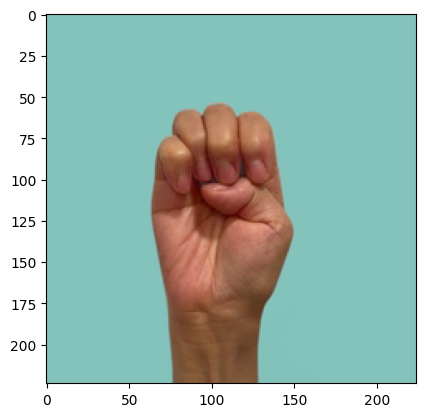

In [ ]:
#Choose arandom image from 0 to 199
index = np.random.randint(0, 199)
test_img=images[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0).cuda()

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])

In [ ]:
# save the model for inference

repr(model)
model_path = os.path.join(tl_wf_dir, "asl_model.pth")
torch.save(model.state_dict(), model_path)

In [ ]:
# load the model state from the pretained model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model_path = "/content/drive/MyDrive/asl_tl_wf/asl_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [ ]:
# trace the model for mobile device

from torch.utils.mobile_optimizer import optimize_for_mobile

device = torch.device("cpu")
model.to(device)

model.eval()
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model, example)
torchscript_model_optimized = optimize_for_mobile(traced_script_module)

model_path = os.path.join(tl_wf_dir, "asl_model_blur_bg.pt")
torchscript_model_optimized._save_for_lite_interpreter(model_path)

In [ ]:
from PIL import Image

image_name = "/content/drive/MyDrive/asl_tl_wf/asl_tl_test/b/104.png"
image = Image.open(image_name)

print(image.format)
print(image.size)
print(image.mode)

PNG
(224, 224)
RGB


In [ ]:
asl_names = [chr(i) for i in range(97, 123)] + ["del", "nothing", "space"]
asl_names = sorted(asl_names)
print(asl_names)

['a', 'b', 'c', 'd', 'del', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'nothing', 'o', 'p', 'q', 'r', 's', 'space', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
model.eval()

t_t = transforms.ToTensor()
t_n = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img = t_n(t_t(image)).unsqueeze(0).cuda()

print(model(test_img))
res = torch.exp(model(test_img))

print("prediction:", asl_names[res.argmax().item()])
image.close()

tensor([[-7.6416e+00, -5.5259e-03, -7.5883e+00, -8.2068e+00, -1.0470e+01,
         -6.5843e+00, -9.7511e+00, -1.0471e+01, -9.7067e+00, -1.0920e+01,
         -8.1493e+00, -8.0478e+00, -9.5781e+00, -9.4436e+00, -1.0980e+01,
         -1.0456e+01, -9.9579e+00, -8.7695e+00, -9.3030e+00, -8.2421e+00,
         -1.0556e+01, -1.0193e+01, -8.5580e+00, -7.8038e+00, -8.0618e+00,
         -8.5231e+00, -9.6372e+00, -9.9913e+00, -1.0538e+01]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
prediction: b


In [ ]:
# video clip inference

import os
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt

base_dir = "/content/drive/MyDrive"
tl_wf_dir = os.path.join(base_dir, "asl_tl_wf")
asl_test_video_dir = os.path.join(tl_wf_dir, "asl_videos", "test")

video_name = os.path.join(asl_test_video_dir, "z.MP4")
cap = cv2.VideoCapture(video_name)

model.eval()

alphabet_stream = ""
while cap.isOpened():
  ret, frame = cap.read()
  if not ret: break

  # image transform
  frame = frame[...,::-1].copy()
  image = Image.fromarray(frame)

  t_t = transforms.ToTensor()
  t_n = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
  test_img = t_n(t_t(image)).unsqueeze(0).cuda()

  # alphabet prediction
  res = torch.exp(model(test_img))
  alphabet_stream += asl_names[res.argmax().item()]

cap.release()
print(alphabet_stream)

xxzxzzzzzzzzzzzzzxxxxxxxxxzzzzzzzzzzzzzzxzzzzzzzxllzzzzzzzzzzzzxzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzlzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
